In [1]:
import os
import warnings
import time

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

In [2]:
import anndata as ad
import scanpy as sc
import scanpy.external as sce
import pandas as pd
import scarches as sca
import matplotlib.pyplot as plt
import numpy as np
import gdown

from scarches.dataset.trvae.data_handling import remove_sparsity

Global seed set to 0


In [3]:
cache_dir = 'cache/'
os.makedirs(cache_dir, exist_ok=True)
os.chdir(cache_dir)

load_existing_model = True

In [4]:
sc.settings.set_figure_params(dpi=200, frameon=False)
sc.set_figure_params(dpi=200)
sc.set_figure_params(figsize=(4, 4))

In [5]:
def display_umap(matrix, color=None, frameon=False, wspace=0.6):
    sc.pp.neighbors(matrix)
    sc.tl.leiden(matrix)
    sc.tl.umap(matrix)
    plt.figure()
    sc.pl.umap(
        matrix,
        color=color,
        frameon=frameon,
        wspace=wspace,
    )

In [6]:
cell_type_key = 'cell_type'
batch_key = 'batch'
unknown_type_key = "Unknown"
cluster_key = "cluster"

### Load Latent Representation Files

In [7]:
reference_latent = sc.read('reference_latent.h5ad')
query_latent = sc.read('query_latent.h5ad')

In [8]:
reference_latent

AnnData object with n_obs × n_vars = 10294 × 10
    obs: 'cell_type', 'batch', 'leiden', 'predictions'
    uns: 'batch_colors', 'cell_type_colors', 'leiden', 'neighbors', 'umap'
    obsm: 'X_umap'
    obsp: 'connectivities', 'distances'

In [9]:
reference_latent.obs['source'] = 'reference'
query_latent.obs['source'] = 'query'

full_latent = reference_latent.concatenate(query_latent)

### Display the UMAP scatterplot

... storing 'source' as categorical


<Figure size 320x320 with 0 Axes>

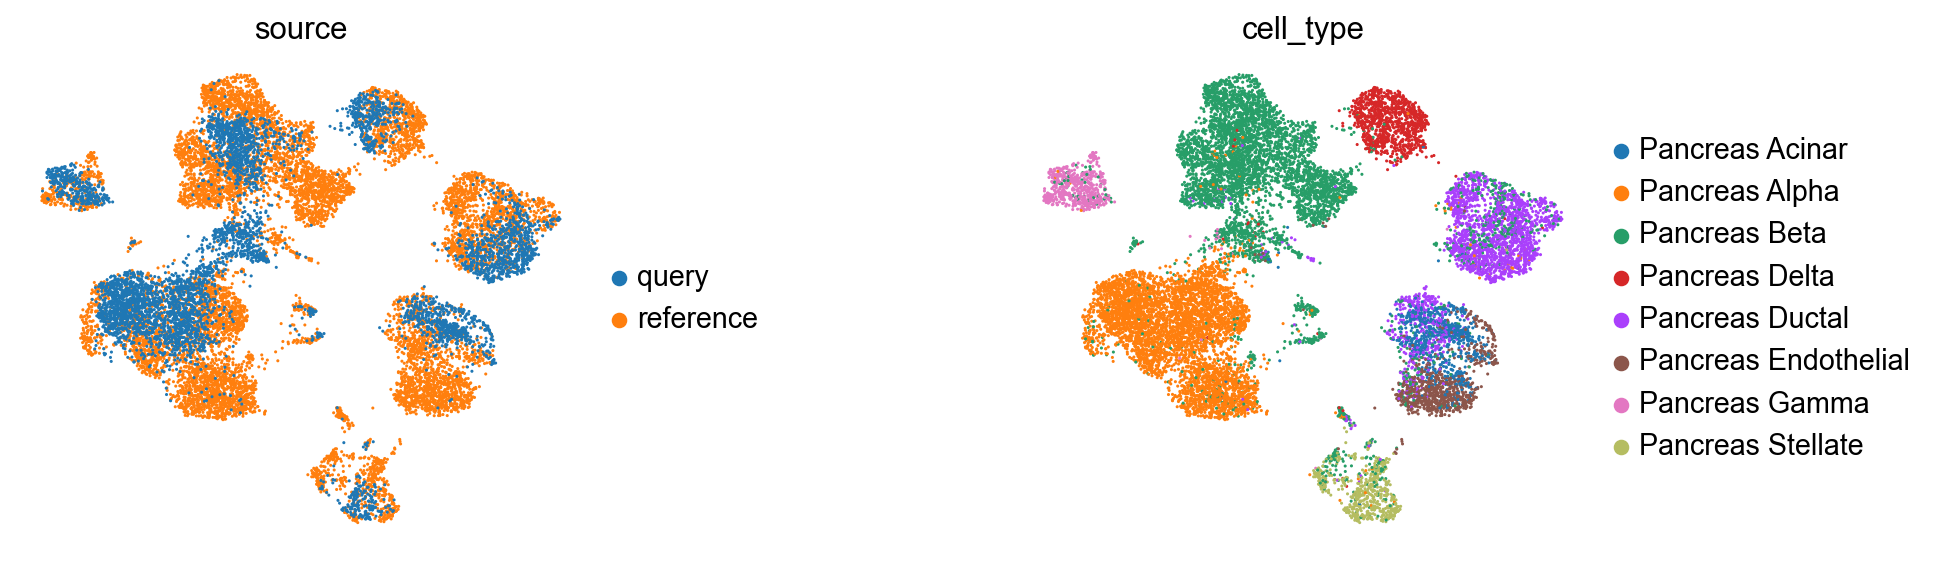

In [10]:
display_umap(full_latent, color=['source', 'cell_type'])

### Benchmarking
Benchmarking the quality of the integration results with the performance of the annotation downstream task.

In [111]:
import sklearn

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

classification_metrics = {
    'Accuracy': sklearn.metrics.accuracy_score,
    'F1 Macro': lambda y_true, y_pred: sklearn.metrics.f1_score(y_true, y_pred, average="macro"),
    'Precision': lambda y_true, y_pred: sklearn.metrics.precision_score(y_true, y_pred,
                                                                        average="macro"),
    'Recall': lambda y_true, y_pred: sklearn.metrics.recall_score(y_true, y_pred, average="macro"),
}

def test(model, X, y):
    scores = {}
    for name, func in classification_metrics.items():
        scores[name] = func(y, model.predict(X))
    return scores

def benchmark(ref_lat, query_lat, model=None):
    if model is None:
        model = ['nn', 'linear_regression', 'decision_tree']
    elif isinstance(model, str):
        model = [model]
        
    model_obj = []
    if 'nn' in model:
        model_obj.append(KNeighborsClassifier())
    if 'linear_regression' in model:
        model_obj.append(LogisticRegression())
    if 'decision_tree' in model:
        model_obj.append(DecisionTreeClassifier())
    
    res = []
    for m in model_obj:
        m.fit(ref_lat.X, ref_lat.obs['cell_type'])
        res.append(test(m, query_lat.X, query_lat.obs['cell_type']))
        
    return res

benchmark(reference_latent, query_latent)

[{'Accuracy': 0.8960460367551513,
  'F1 Macro': 0.8578787156261889,
  'Precision': 0.8586294998595565,
  'Recall': 0.8711748606384128},
 {'Accuracy': 0.907183961388528,
  'F1 Macro': 0.8552472210351838,
  'Precision': 0.8818105709450869,
  'Recall': 0.8578672627515865},
 {'Accuracy': 0.8657880081678114,
  'F1 Macro': 0.8085723401805813,
  'Precision': 0.8137807370010464,
  'Recall': 0.8141418034905643}]

Harmony-Based Anchor Cell Recommendation (V2)
---

In [12]:
from harmonypy import run_harmony

In [13]:
hm = run_harmony(full_latent.X, full_latent.obs, 'source')

2022-02-14 20:53:18,228 - harmonypy - INFO - Iteration 1 of 10
2022-02-14 20:53:21,205 - harmonypy - INFO - Iteration 2 of 10
2022-02-14 20:53:24,056 - harmonypy - INFO - Iteration 3 of 10
2022-02-14 20:53:26,998 - harmonypy - INFO - Iteration 4 of 10
2022-02-14 20:53:29,910 - harmonypy - INFO - Iteration 5 of 10
2022-02-14 20:53:32,812 - harmonypy - INFO - Converged after 5 iterations


In [14]:
hm.R.shape

(100, 15681)

In [96]:
conf_threshold = 0.3

cluster_assignment = np.zeros(hm.R.shape)
for row, col in enumerate(hm.R.argmax(axis=0)):
    cluster_assignment[col, row] = 1
cluster_assignment[:, (hm.R > conf_threshold).sum(axis=0) == 0] = 0

In [97]:
count = cluster_assignment.sum(axis=1)

full_obs = full_latent.obs.reset_index(drop=True)
query_cell_index = full_obs[full_obs['source'] == 'query'].index
reference_cell_index = full_obs[full_obs['source'] == 'reference'].index

query_count = cluster_assignment[:, query_cell_index].sum(axis=1)
reference_count = cluster_assignment[:, reference_cell_index].sum(axis=1)

In [98]:
query_centers = np.dot(cluster_assignment[:, query_cell_index], 
                       query_latent.X) / query_count[:, None]
reference_centers = np.dot(cluster_assignment[:, reference_cell_index], 
                           reference_latent.X) / reference_count[:, None]
cluster_distances = np.linalg.norm(query_centers-reference_centers, axis=1)

/Users/chengfurui/Projects/polyphony/venv/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  
/Users/chengfurui/Projects/polyphony/venv/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


In [99]:
import pandas as pd

cluster_statics = pd.DataFrame(dict(
    count=count, 
    query_count=query_count, 
    reference_count=reference_count,
    cluster_distances=cluster_distances,
)).sort_values(by=['count'], ascending=False)
cluster_statics = cluster_statics[
    (cluster_statics['query_count'] > 0) 
    & (cluster_statics['reference_count'] > 0)
]
cluster_statics.head()

,count,query_count,reference_count,cluster_distances
9,264.0,141.0,123.0,0.846655
20,249.0,141.0,108.0,1.038462
85,208.0,53.0,155.0,1.745578
87,198.0,36.0,162.0,3.224700
78,196.0,80.0,116.0,1.621893


In [100]:
cluster_statics = cluster_statics.sort_values(by=['cluster_distances'])
cluster_statics

,count,query_count,reference_count,cluster_distances
33,121.0,41.0,80.0,0.634285
53,144.0,77.0,67.0,0.691370
48,85.0,28.0,57.0,0.738382
65,172.0,35.0,137.0,0.745304
35,177.0,76.0,101.0,0.814766
...,...,...,...,...
99,164.0,15.0,149.0,2.160595
24,137.0,33.0,104.0,2.176632
46,181.0,33.0,148.0,2.688494
42,162.0,27.0,135.0,3.052328


## Correction (Method-1)

In [101]:
bias_mat = reference_centers - query_centers
bias_mat[bias_mat != bias_mat] = 0
fix = np.dot(cluster_assignment[:, query_cell_index].T, bias_mat)

In [102]:
fixed_query_latent = sc.AnnData(query_latent.X + fix)
fixed_query_latent.obs['source'] = 'query'
fixed_query_latent.obs['cell_type'] = query_latent.obs['cell_type']

... storing 'source' as categorical


<Figure size 320x320 with 0 Axes>

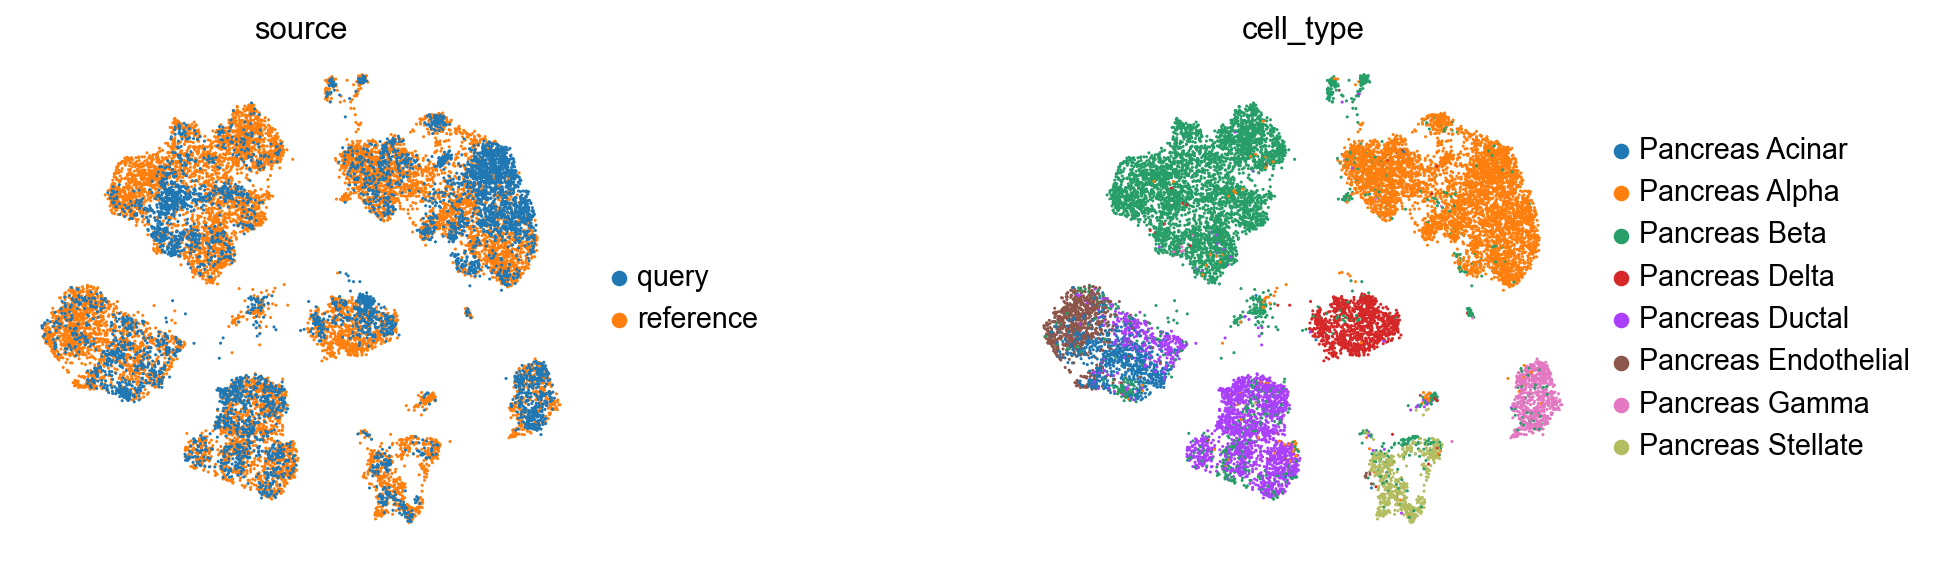

In [103]:
fixed_full_latent = reference_latent.concatenate(fixed_query_latent)
display_umap(fixed_full_latent, color=['source', 'cell_type'])

In [112]:
benchmark(reference_latent, fixed_query_latent)

[{'Accuracy': 0.8915908669018007,
  'F1 Macro': 0.8453710735937886,
  'Precision': 0.8249487528751295,
  'Recall': 0.8797832737614995},
 {'Accuracy': 0.8953035084462595,
  'F1 Macro': 0.8494124179592295,
  'Precision': 0.8314314099751237,
  'Recall': 0.8783069483796313},
 {'Accuracy': 0.8604046779283461,
  'F1 Macro': 0.8011005212792772,
  'Precision': 0.7934420251402735,
  'Recall': 0.8203333782935354}]

## Correction (method-2)

In [105]:
valid_clusters = cluster_statics.index

In [106]:
def cluster_agg(latent_mat, cluster_assignment):
    inner_var_df = pd.DataFrame(latent_mat)
    inner_var_df['cluster'] = cluster_assignment.argmax(axis=0)
    inner_var_df = inner_var_df[cluster_assignment.sum(axis=0) > 0]
    query_cluster_group = inner_var_df.groupby('cluster')
    return query_cluster_group.agg(["mean", "var"])

query_assign = cluster_assignment[:, query_cell_index]
query_cluster = cluster_agg(query_latent.X, query_assign).loc[valid_clusters]
query_cluster

0                   1                   2                   3  \
        mean       var      mean       var      mean       var      mean   
33 -0.402736  0.234703 -0.711557  0.173382 -0.883937  0.168197  0.741325   
53  0.244693  0.075057  1.730254  0.231174 -0.187583  0.199537  1.513857   
48 -0.072529  0.331789  0.169189  0.487791 -0.792382  0.328704 -0.051803   
65 -0.580848  0.321484  0.854846  0.100877  0.569396  0.185863  1.819746   
35  0.628235  0.240649  1.021985  0.176501 -0.962283  0.217675 -0.574353   
..       ...       ...       ...       ...       ...       ...       ...   
99 -0.336506  0.228036 -0.055063  0.165236 -0.533188  0.244968  0.049274   
24  0.675528  0.146451  0.821077  0.438508 -2.080020  0.351399  0.311604   
46  0.253989  0.360831  0.528362  0.440093 -2.763909  0.289566 -0.185178   
42 -0.458274  0.327781  0.214919  0.202245 -2.673976  0.360184 -0.225182   
87 -1.319995  0.114937  0.060543  0.247546 -2.658890  0.392200 -0.680817   

                     4                   5                   6            \
         var      mean       var      mean       var      mean       var   
33  0.131313 -0.736496  0.152682 -0.985002  0.196040  0.112936  0.145428   
53  0.111877  0.809574  0.187887  0.697665  0.241889 -1.193666  0.146227   
48  0.306528 -0.142110  0.344110  1.351186  0.437365 -1.609752  0.576188   
65  0.122519 -0.767525  0.303513  0.935442  0.138638  0.820441  0.220457   
35  0.418322 -0.418345  0.184247  0.878267  0.281273 -1.296322  0.187356   
..       ...       ...       ...       ...       ...       ...       ...   
99  0.353635 -0.741962  0.143046 -0.256236  0.333056  1.421186  0.146814   
24  0.283398 -0.792150  0.213110 -0.050168  0.252986  0.795039  0.089291   
46  0.212806  0.884818  0.261307  0.282520  0.296356  0.606302  0.147755   
42  0.206563 -0.517681  0.328442 -0.957839  0.187401  0.603844  0.111164   
87  0.267194 -0.135284  0.298532 -0.778737  0.217076  0.452996  0.125226   

           7                   8                   9            
        mean       var      mean       var      mean       var  
33 -1.297640  0.216104 -1.587855  0.169282  0.554742  0.258141  
53 -1.177331  0.064343  0.179306  0.163950 -0.430420  0.294914  
48 -0.909283  0.309160  1.185546  0.235471 -0.730368  0.134830  
65 -0.442417  0.153922 -0.781367  0.201173 -0.545734  0.168786  
35  1.348927  0.079312 -0.868713  0.254138  1.801699  0.208272  
..       ...       ...       ...       ...       ...       ...  
99 -0.727282  0.276392 -1.256509  0.120462  1.167324  0.179394  
24  1.114562  0.330039  0.612717  0.183685 -2.048183  0.277028  
46  1.246275  0.236045  0.496500  0.181943 -0.999267  0.240249  
42  1.533024  0.100952  0.113263  0.216723 -1.712120  0.219704  
87  1.788100  0.105312 -0.423598  0.087230 -0.798303  0.257945  

[82 rows x 20 columns]

In [107]:
ref_assign = cluster_assignment[:, reference_cell_index]
ref_cluster = cluster_agg(reference_latent.X, ref_assign).loc[valid_clusters]
ref_cluster

0                   1                   2                   3  \
        mean       var      mean       var      mean       var      mean   
33 -0.422986  0.213053 -0.847459  0.175081 -0.604706  0.224086  0.446949   
53  0.251538  0.081543  1.466455  0.231747 -0.330236  0.292685  1.567197   
48 -0.337596  0.430772  0.092788  0.667033 -0.639525  0.243058  0.109550   
65 -0.884458  0.260008  0.613867  0.241309  0.885371  0.260309  1.582773   
35  0.425792  0.464404  1.299662  0.230474 -0.749753  0.216358 -0.101796   
..       ...       ...       ...       ...       ...       ...       ...   
99 -1.006941  0.337349 -0.625304  0.275450  0.483315  0.232965 -0.057256   
24  0.360008  0.256937  0.271873  0.153665 -0.209785  0.141071  0.417798   
46  0.303764  0.306678  0.591773  0.187596 -0.407298  0.224588  0.357928   
42 -0.084716  0.180430 -0.189981  0.259894  0.006798  0.187670  0.584892   
87 -1.148990  0.216722 -0.333375  0.301800 -0.047394  0.234762  0.364498   

                     4                   5                   6            \
         var      mean       var      mean       var      mean       var   
33  0.330006 -0.579842  0.265379 -0.894503  0.229987  0.471040  0.224891   
53  0.224993  0.974865  0.240346  0.775827  0.410458 -1.279114  0.367759   
48  0.404240 -0.651610  0.250794  1.203348  0.282643 -1.625218  0.594234   
65  0.156577 -1.073937  0.332519  0.791875  0.340686  0.855776  0.238243   
35  0.324302 -0.654559  0.388448  0.628248  0.334567 -1.092855  0.435253   
..       ...       ...       ...       ...       ...       ...       ...   
99  0.253414 -0.610775  0.281599 -0.711158  0.270392  2.169329  0.138241   
24  0.208276 -0.530978  0.199050  0.246408  0.180308  1.026796  0.170576   
46  0.322340  0.712219  0.174787  0.193249  0.363211  0.524066  0.261460   
42  0.327357 -0.397118  0.381171 -0.600800  0.273389  1.121167  0.211987   
87  0.338834 -0.541518  0.365503 -0.282586  0.389644  0.766277  0.265575   

           7                   8                   9            
        mean       var      mean       var      mean       var  
33 -1.137038  0.227778 -1.750376  0.181894  0.479671  0.238282  
53 -0.597978  0.104235  0.106182  0.214169 -0.371839  0.269200  
48 -0.551107  0.240308  1.268955  0.196377 -0.783076  0.393995  
65 -0.361982  0.136999 -0.457299  0.168355 -0.694032  0.225698  
35  1.447590  0.116002 -0.666650  0.151843  1.542840  0.177092  
..       ...       ...       ...       ...       ...       ...  
99 -0.371407  0.113562 -0.193513  0.195214  0.268213  0.286072  
24  1.707220  0.120212  1.094159  0.117099 -2.234154  0.161870  
46  1.529801  0.197667  1.182896  0.179735 -1.880674  0.242365  
42  2.047492  0.119063  0.816349  0.164349 -1.754555  0.176377  
87  2.149910  0.190121  0.776488  0.227044 -1.268655  0.254159  

[82 rows x 20 columns]

In [149]:
query_mean = query_cluster[query_cluster.columns[::2]].fillna(0)
query_var = query_cluster[query_cluster.columns[1::2]].fillna(1)
ref_mean = ref_cluster[ref_cluster.columns[::2]].fillna(0)
ref_var = ref_cluster[ref_cluster.columns[1::2]].fillna(1)

query_assign = cluster_assignment[valid_clusters][:, query_cell_index]

mean_query = np.dot(query_assign.T, query_mean.values)
var_query = np.dot(query_assign.T, query_var.values)
var_query[var_query == 0] = 1

mean_ref = np.dot(query_assign.T, ref_mean.values)
var_ref = np.dot(query_assign.T, ref_var.values)
var_ref[var_ref == 0] = 1

X = query_latent.X - mean_query + mean_ref
X += (query_latent.X - mean_query) * (var_ref / var_query - 1)

In [150]:
fully_fixed_query_latent = sc.AnnData(X)
fully_fixed_query_latent.obs['source'] = 'query'
fully_fixed_query_latent.obs['cell_type'] = query_latent.obs['cell_type']

... storing 'source' as categorical


<Figure size 320x320 with 0 Axes>

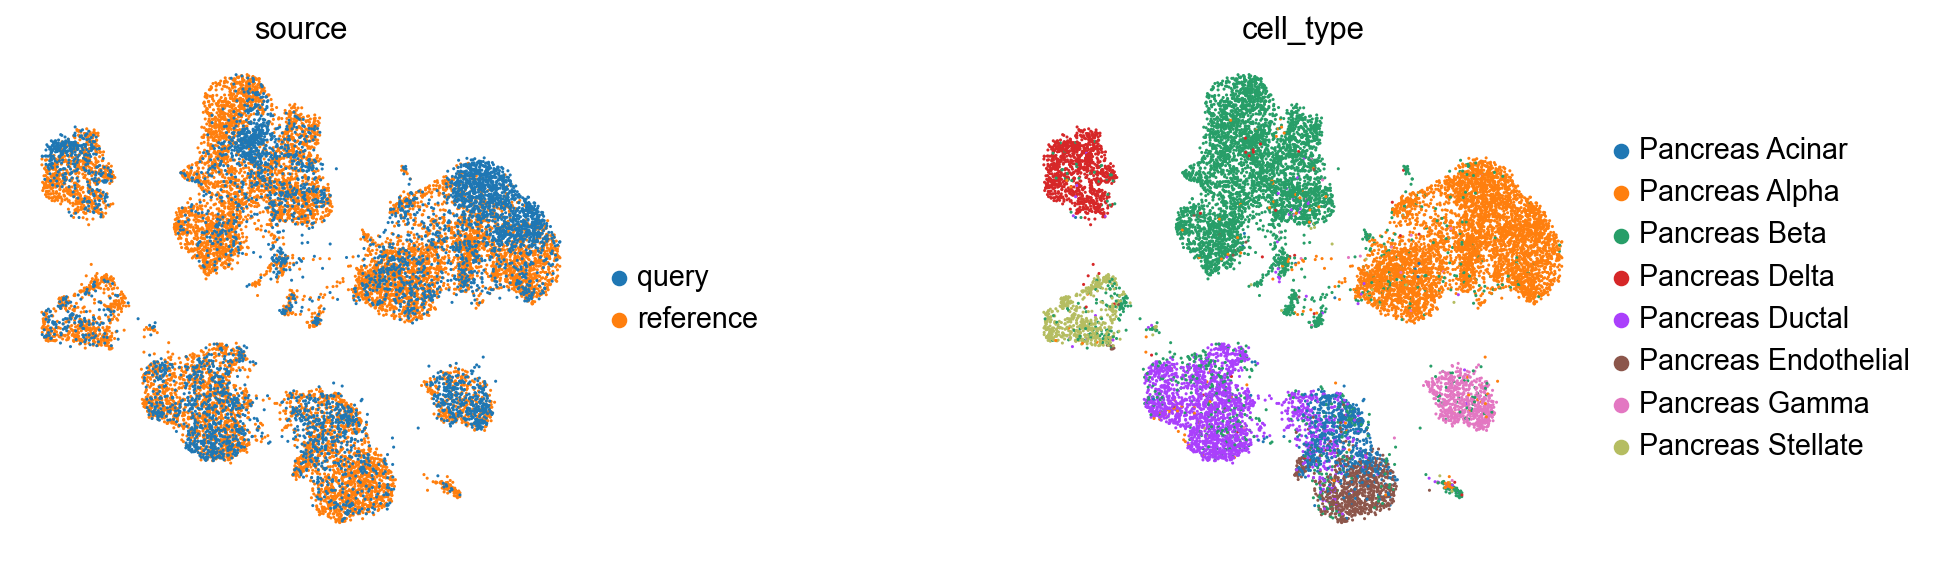

In [151]:
fixed_full_latent = reference_latent.concatenate(fully_fixed_query_latent)
display_umap(fixed_full_latent, color=['source', 'cell_type'])

In [152]:
benchmark(reference_latent, fully_fixed_query_latent)

[{'Accuracy': 0.8800816781139781,
  'F1 Macro': 0.8266947682045029,
  'Precision': 0.8186335369518369,
  'Recall': 0.8519896138201313},
 {'Accuracy': 0.877111564878411,
  'F1 Macro': 0.8231280119142151,
  'Precision': 0.8141239646970205,
  'Recall': 0.8500666124830126},
 {'Accuracy': 0.8130684982364953,
  'F1 Macro': 0.7341725336408637,
  'Precision': 0.7402155089413442,
  'Recall': 0.748698027437252}]

---